# 1. Import libraries

# References:
1. https://www.kaggle.com/xwxw2929/rossmann-sales-top1

In [1]:
import warnings
import pandas                  as pd
import seaborn                 as sns
import statsmodels.api         as sm
import statsmodels.formula.api as smf

from matplotlib              import pyplot as plt
from IPython.core.display    import HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
from sklearn.ensemble        import RandomForestRegressor
from sklearn                 import linear_model
from sklearn                 import metrics

warnings.filterwarnings('ignore')

## 0.1. Helper Functions

In [2]:
# --- Jupyter Notebook Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
train = pd.read_csv( '../data/train.csv' )
store = pd.read_csv( '../data/store.csv' )

# Merge dataset
#df_raw = pd.merge( df_sales_raw, df_stores_raw, on='Store', how='left' )

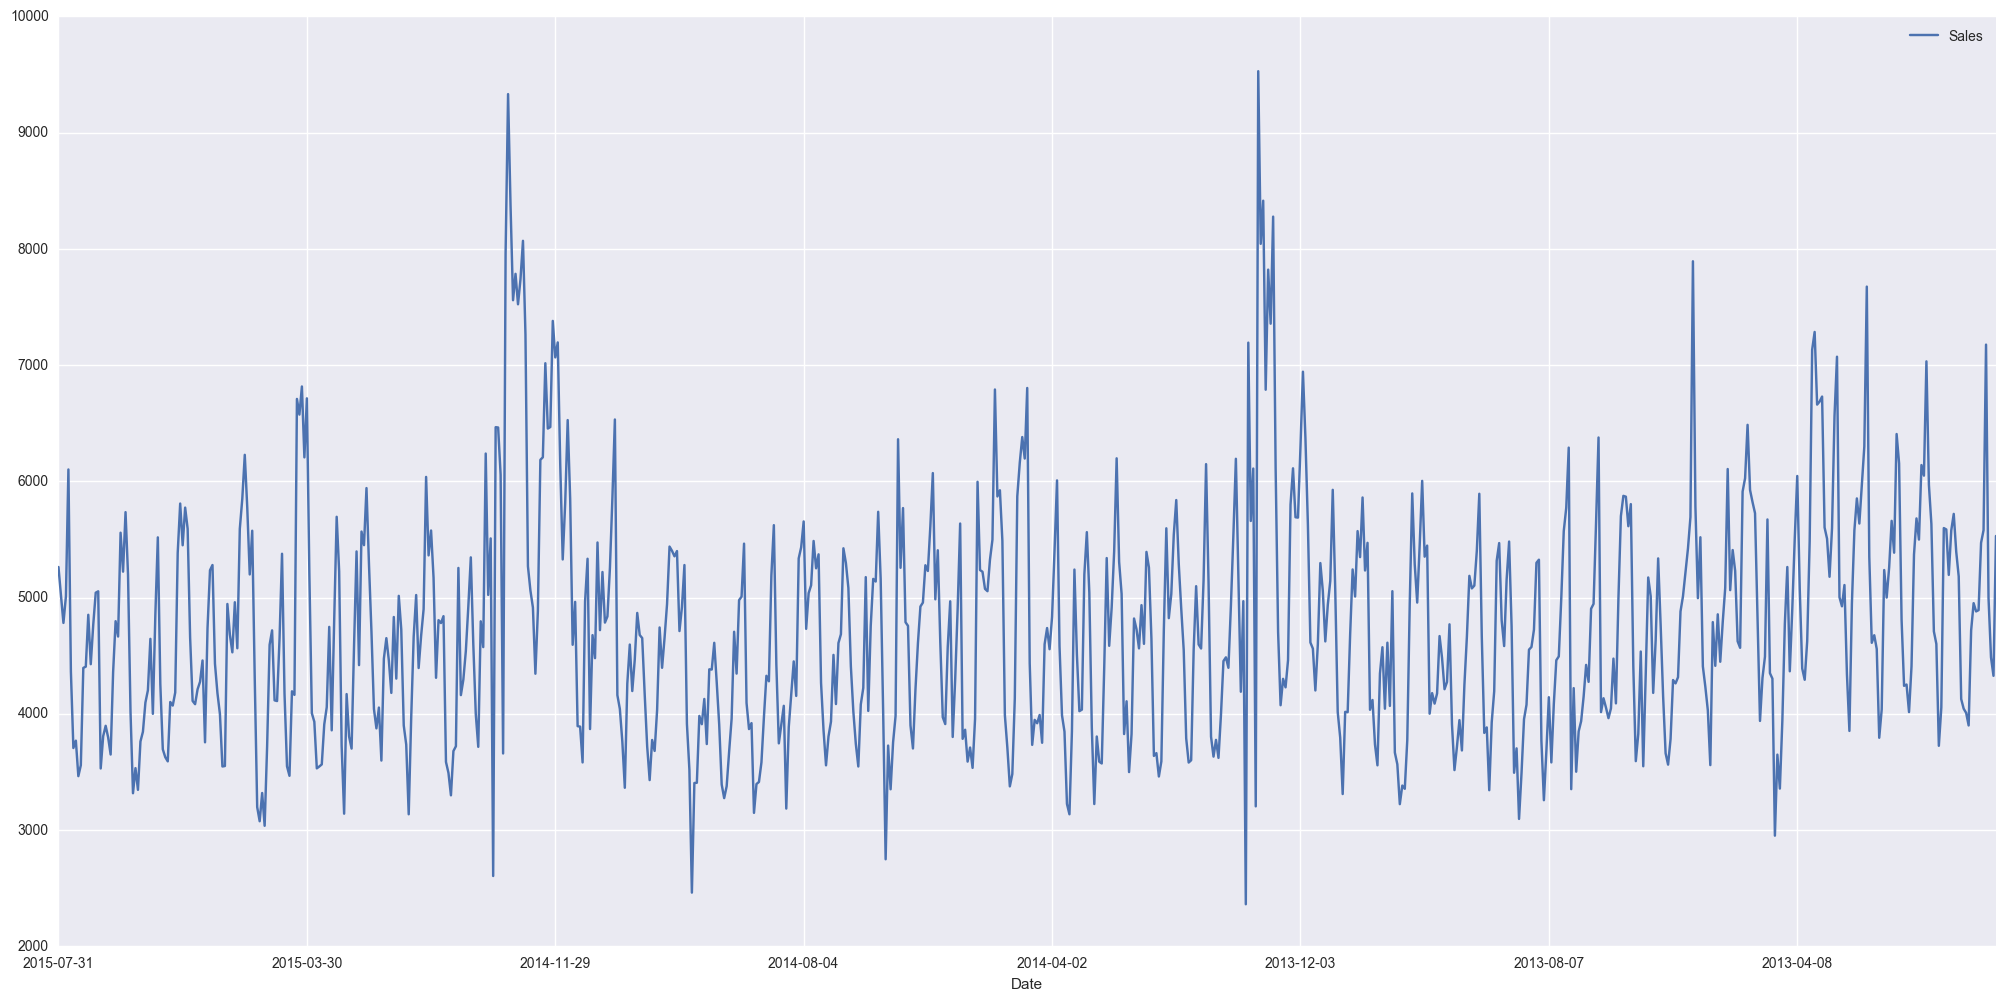

In [5]:
# sales of store 1 full time
strain = train[train['Sales'] > 0]
strain.loc[strain['Store'] == 1, ['Date', 'Sales']].plot(x='Date', y='Sales' )

In [6]:
# fillna in store with 0 has better result than median()
#store['CompetitionDistance'].fillna( store['CompetitionDistance'].median(), inplace=True )
#store['CompetitionOpenSinceYear'].fillna( store['CompetitionDistance'].median(), inplace=True )
#store['CompetitionOpenSinceMonth'].fillna( store['CompetitionDistance'].median(), inplace=True )

store.fillna( 0, inplace=True )


In [7]:
train = pd.merge( train, store, on='Store' )

In [8]:
# split the last 6 weeks data as hold-out set
train = train.sort_values( ['Date'], ascending=False )

ho_test = train[:6*7*1115]
ho_train = train[6*7*1115:]

In [9]:
# only use data of Sales > 0 and Open is 1
ho_test = ho_test[ ho_test['Open'] != 0 ]
ho_test = ho_test[ ho_test['Sales'] > 0 ]

ho_train = ho_train[ ho_train['Open'] != 0 ]
ho_train = ho_train[ ho_train['Sales'] > 0 ]

In [12]:
# feature creation
def features_create( data ):
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace( mappings, inplace=True )
    data.Assortment.replace( mappings, inplace=True )
    data.StateHoliday.replace( mappings, inplace=True )
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    data['CompetitionOpen'] = 12 * ( data.Year - data.CompetitionOpenSinceYear ) + ( data.Month - data.CompetitionOpenSinceMonth )
    data['PromoOpen'] = 12 * ( data.Year - data.Promo2SinceYear ) + ( data.WeekOfYear - data.Promo2SinceWeek ) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply( lambda x: x if x > 0 else 0 )
    data['PromoOpen'] = data.PromoOpen.apply( lambda x: x if x > 0 else 0 )
    
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map( month2str )
    data.loc[ data.PromoInterval == 0, 'PromoInterval' ] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split( ',' ):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
                
    return data

In [13]:
features_create( ho_train )
features_create( ho_test )
print( 'Features creation finished' )

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [ ]:
ho_train.head()